
**Goal**:

Cluster players based on their entire career data to identify distinct playing styles and patterns. Focus on individual player styles using both physical and technical aggregated data.


**Dataset**:

Career-aggregated data for players, encompassing both physical and technical attributes.


**Challenges**:

The diversity in player age and gender within the dataset may introduce significant variabili, requiring sophisticated clustering techniques to handle heterogeneity. Ensuring the clustering model accurately reflects the nuances of different playing careers and adapts to the wide range of data characteristics.

In [ ]:
import pandas as pd
import plotly.express as px
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import numpy as np

In [ ]:
data = pd.read_csv('xseed_aggregate_stats.csv')

In [ ]:
data.head()

walking metri percorsi camminando  
max_speed velocità massima  
standing metri percorsi lentamente  
running_distance metri percorsi correndo  
sprint numero di sprint  
high_intensity_distance metri percorsi ad alta intensità comprende anche sprints   

In [ ]:
#Normalize the data on time_played
norm = pd.DataFrame()
not_normalize = ['time_played','max_speed','hash']
for column in data.columns:
    if column not in not_normalize:
        norm[column] = data[column] / data['time_played']
    else:
        norm[column] = data[column]

In [ ]:
#remove players with less than 60 (avg game) minutes of play
norm = norm[norm['time_played'] > 60]

In [ ]:
norm.head()

In [ ]:
norm.describe()

In [ ]:
'''for column in norm.columns[:-2]:
    fig = px.box(norm, x=column)
    fig.show()'''

In [ ]:
norm.columns

In [ ]:
ball = norm[['time_played', 'touches', 'passes', 'shots','crosses','hash']].copy()

In [ ]:
norm['total_distance'] = norm['walking'] + norm['running_distance'] + norm['standing']
norm['medium_intensity_running'] = norm['high_intensity_running'] - norm['sprints_distance']
norm['low_intensity_running'] = norm['running_distance'] - norm['high_intensity_running']
#remove old columns
norm = norm.drop(columns=['running_distance','high_intensity_running'])
norm['high_intensity_running'] = norm['sprints_distance']
norm = norm.drop(columns=['sprints_distance'])

In [ ]:
norm.head()

In [ ]:
action = norm[['time_played', 'km_covered','walking','standing','max_speed', 'total_distance','sprints', 'medium_intensity_running','accelerations','decelerations','high_intensity_running','low_intensity_running','hash']].copy()

In [ ]:
not_mul = ['time_played','hash','max_speed']

action.loc[:, ~action.columns.isin(not_mul)] *= 60

In [ ]:
ball_action= ['passes', 'shots','crosses']
for col in ball_action:
    ball[col] = ball[col] * 100 / (ball['touches'])

In [ ]:
ball.head()

In [ ]:
action.head()

In [503]:
def elbow_method(data):   
    Sum_of_squared_distances = []
    K = range(1,15)
    for k in K:
        km = KMeans(n_clusters=k)
        km = km.fit(data)
        Sum_of_squared_distances.append(km.inertia_)
    plt.plot(K, Sum_of_squared_distances, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Sum_of_squared_distances')
    plt.title('Elbow Method For Optimal k')
    plt.show()

In [ ]:
elbow_method(ball.iloc[:,1:-1])

In [499]:
def kmeans(data, n_clusters, random_state=1234):
    km = KMeans(n_clusters=n_clusters, random_state=random_state)
    cluster_labels = km.fit_predict(data)
    return cluster_labels

In [ ]:
norm['ball_cluster'] = kmeans(ball.iloc[:,1:-1],5)

In [500]:
def plot_scatter(data,col1,col2,cluster_labels):
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(data[[col1]], data[[col2]], c=cluster_labels, cmap='viridis')
    plt.scatter(data[[col1]], data[[col2]], c=cluster_labels, cmap='viridis')
    plt.xlabel(col1)
    plt.ylabel(col2)
    plt.title('Data with Clusters')
    legend1 = plt.legend(*scatter.legend_elements(),
                    loc="upper right", title="Clusters")
    plt.gca().add_artist(legend1)
    plt.show()

In [ ]:
plot_scatter(ball,'passes','shots',norm['ball_cluster'])

In [ ]:
plot_scatter(ball,'passes','crosses',norm['ball_cluster'])

In [ ]:
plot_scatter(ball,'shots','crosses',norm['ball_cluster'])

In [ ]:
cols = action.columns.tolist()
cols.insert(1, cols.pop(cols.index('hash')))
action = action.reindex(columns=cols)

In [ ]:
action.head()

In [ ]:
new_action = action[['total_distance','standing','walking','low_intensity_running','medium_intensity_running','high_intensity_running']].copy()

In [ ]:
new_action.head()

In [ ]:
elbow_method(new_action.iloc[:,1:])

In [ ]:
scaler = StandardScaler()
scaler.fit(new_action.iloc[:,1:])
scaled_features = scaler.transform(new_action.iloc[:,1:])
scaled_features_df = pd.DataFrame(scaled_features, index=new_action.index, columns=new_action.columns[1:])
cluster_labels = kmeans(scaled_features_df,4)
norm['action_cluster'] = cluster_labels
scaled_features_df['total_distance'] = new_action['total_distance']

In [ ]:
plot_scatter(new_action,'walking','medium_intensity_running',norm['action_cluster'])

In [ ]:
plot_scatter(new_action,'walking','medium_intensity_running',norm['action_cluster'])

In [ ]:
plot_scatter(new_action,'walking','low_intensity_running',norm['action_cluster'])

In [ ]:
plot_scatter(new_action,'high_intensity_running','medium_intensity_running',norm['action_cluster'])

In [ ]:
plot_scatter(new_action,'low_intensity_running','medium_intensity_running',norm['action_cluster'])

In [ ]:
plot_scatter(new_action,'standing','high_intensity_running',norm['action_cluster'])

In [ ]:
plot_scatter(new_action,'total_distance','medium_intensity_running',norm['action_cluster'])

In [ ]:
clusters = norm['action_cluster'].unique()
data = [norm[norm['action_cluster'] == cluster]['max_speed'] for cluster in clusters]
plt.boxplot(data)
plt.show()

In [ ]:
norm['ball_cluster'].value_counts()

In [ ]:
norm['action_cluster'].value_counts()

In [ ]:
ball_clusters = norm['ball_cluster'].max()

for cluster in range(0,ball_clusters+1):
    subset = norm[norm['ball_cluster'] == cluster]
    plt.figure(figsize=(8, 6))
    sns.histplot(data=subset, x='action_cluster', bins=range(norm['action_cluster'].min(), norm['action_cluster'].max()),discrete=True,shrink=0.8)
    plt.xticks(range(0, 4))
    plt.title(f'Histogram for ball cluster {cluster}')
    plt.show()

In [ ]:
#histogram with weights
total_counts = norm['action_cluster'].value_counts()
weights = norm['action_cluster'].apply(lambda x: 1 / total_counts[x])
ball_clusters = norm['ball_cluster'].max() + 1

for cluster in range(0, ball_clusters):
    subset = norm[norm['ball_cluster'] == cluster]
    plt.figure(figsize=(8, 6))
    sns.histplot(data=subset, x='action_cluster', bins=range(norm['action_cluster'].min(), norm['action_cluster'].max()), weights=weights, discrete=True, shrink=0.8)
    plt.xticks(range(0, 4))
    plt.title(f'Weighted Histogram for ball cluster {cluster}')
    plt.show()

In [ ]:
sprint_dist = norm['high_intensity_running'] / norm['sprints']
sprint_dist = sprint_dist.fillna(0)
sprints = norm['sprints'] * 60

plt.figure(figsize=(8, 6))
scatter = plt.scatter(sprint_dist, sprints, c=norm['action_cluster'], cmap='viridis')
plt.xlabel('Sprint Distance')
plt.ylabel('Sprints')
plt.title('Sprint Distance vs Sprints')
legend1 = plt.legend(*scatter.legend_elements(),
                    loc="upper right", title="Clusters")
plt.gca().add_artist(legend1)
plt.show()

In [494]:
#move hash to the second column
cols = norm.columns.tolist()
cols.insert(1, cols.pop(cols.index('hash')))
norm = norm.reindex(columns=cols)

In [495]:
###########
#Divide in 3 datasets based on max_speed (field type?)
pitch_5 = norm[norm['max_speed'] < 22]
pitch_7 = norm[(norm['max_speed'] >= 22) & (norm['max_speed'] < 27)]
pitch_11 = norm[norm['max_speed'] >= 27]

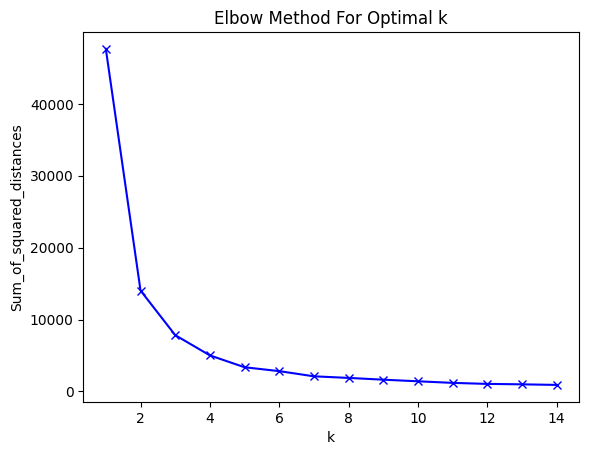

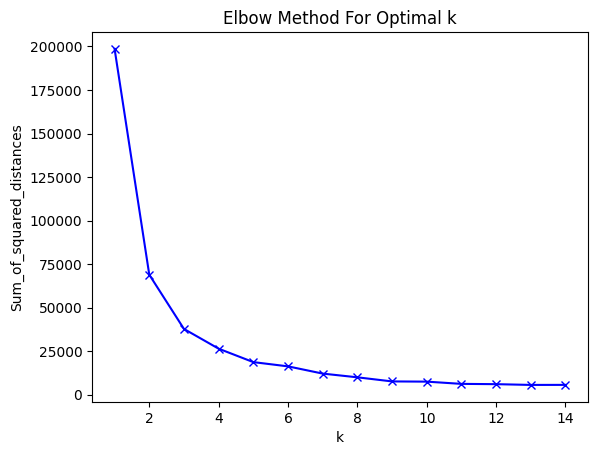

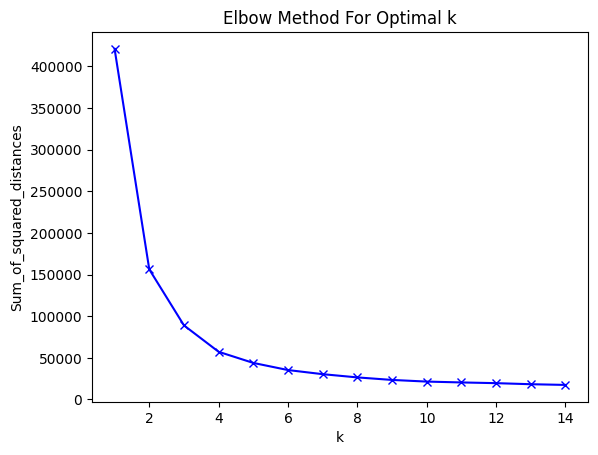

In [509]:
#same cluster but based on pitch type
elbow_method(pitch_5.iloc[:,2:])
elbow_method(pitch_7.iloc[:,2:])
elbow_method(pitch_11.iloc[:,2:])

In [517]:
action_col = ['total_distance','standing','walking','low_intensity_running','medium_intensity_running','high_intensity_running']
ball_col = ['passes', 'shots','crosses']
pitch_5['action_cluster'] = kmeans(pitch_5[action_col],4)
pitch_7['action_cluster'] = kmeans(pitch_7[action_col],4)
pitch_11['action_cluster'] = kmeans(pitch_11[action_col],4)
ball_action= ['passes', 'shots','crosses']
for col in ball_action:
    pitch_5[col] = pitch_5[col] * 100 / (pitch_5['touches'])
    pitch_7[col] = pitch_7[col] * 100 / (pitch_7['touches'])
    pitch_11[col] = pitch_11[col] * 100 / (pitch_11['touches'])

pitch_5['ball_cluster'] = kmeans(pitch_5[ball_col],5)
pitch_7['ball_cluster'] = kmeans(pitch_7[ball_col],5)
pitch_11['ball_cluster'] = kmeans(pitch_11[ball_col],5)

/var/folders/rm/vr__kwkd7dz9z9mvt6z1hm2r0000gn/T/ipykernel_44225/877544661.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/rm/vr__kwkd7dz9z9mvt6z1hm2r0000gn/T/ipykernel_44225/877544661.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/rm/vr__kwkd7dz9z9mvt6z1hm2r0000gn/T/ipykernel_44225/877544661.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

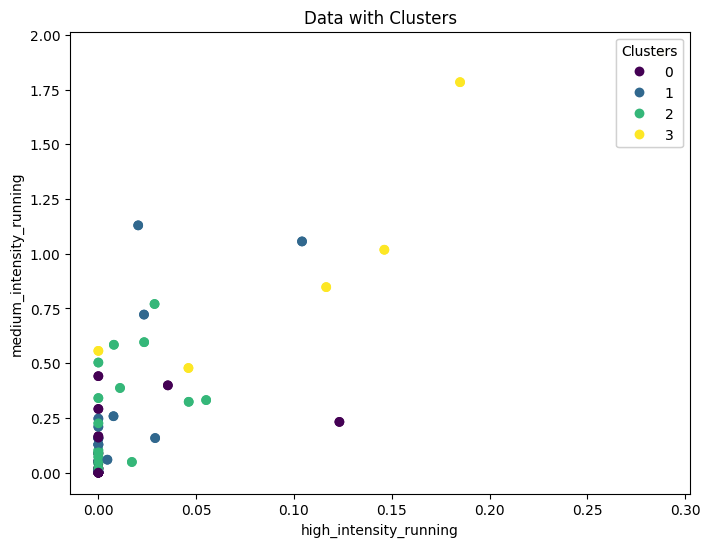

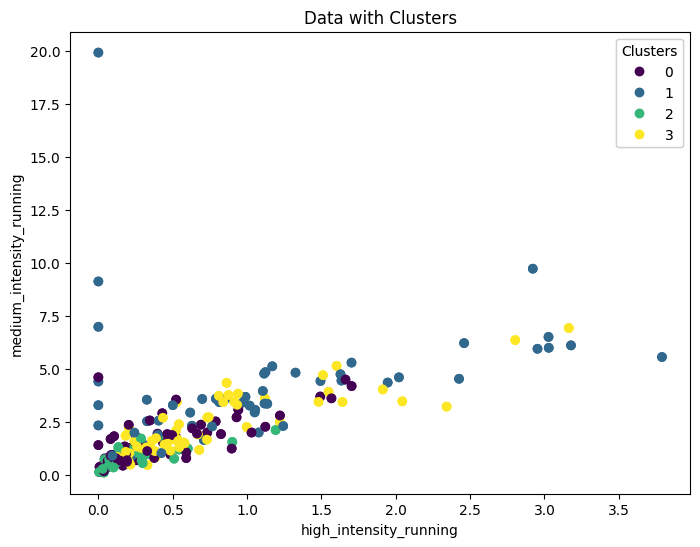

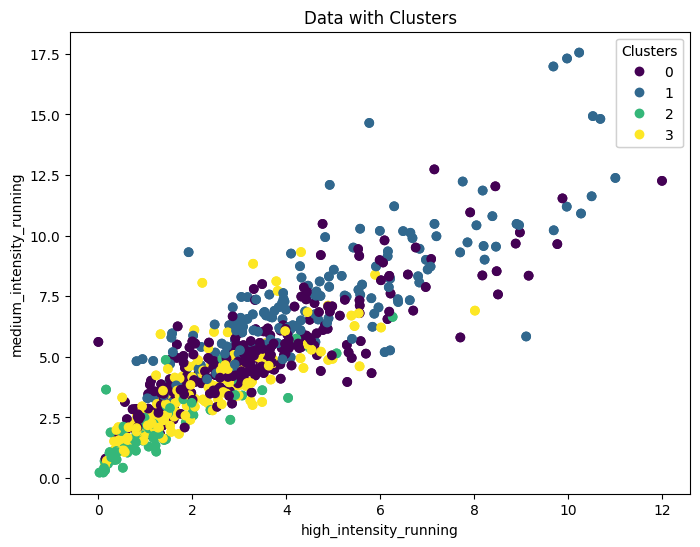

In [512]:
#plot scatter for pitch action_cluster
plot_scatter(pitch_5,'high_intensity_running','medium_intensity_running',pitch_5['action_cluster'])
plot_scatter(pitch_7,'high_intensity_running','medium_intensity_running',pitch_7['action_cluster'])
plot_scatter(pitch_11,'high_intensity_running','medium_intensity_running',pitch_11['action_cluster'])

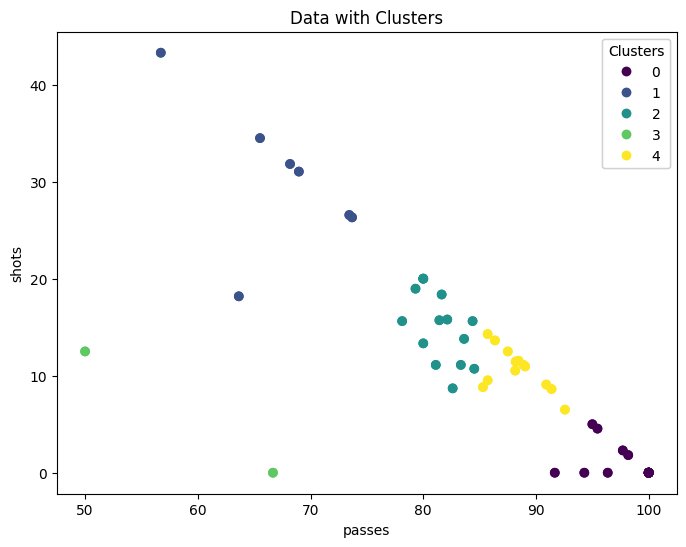

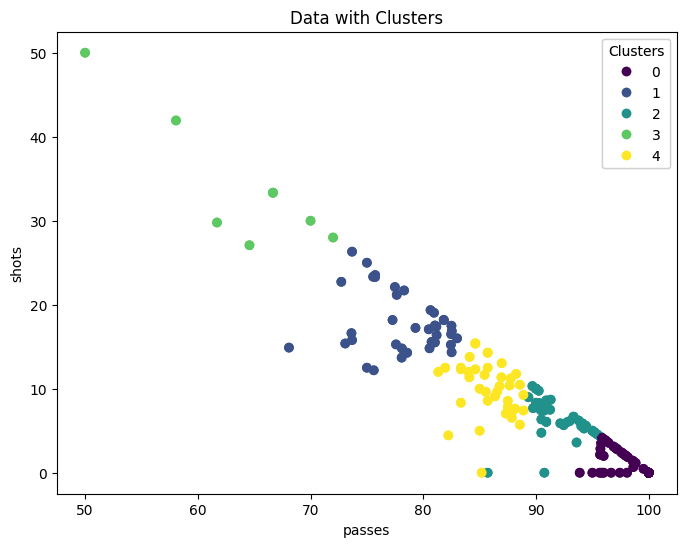

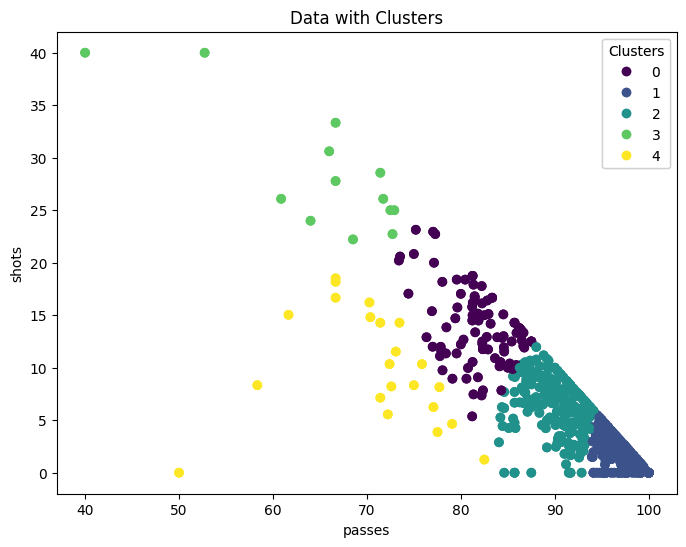

In [518]:
#plot scatter for pitch ball_cluster
plot_scatter(pitch_5,'passes','shots',pitch_5['ball_cluster'])
plot_scatter(pitch_7,'passes','shots',pitch_7['ball_cluster'])
plot_scatter(pitch_11,'passes','shots',pitch_11['ball_cluster'])

In [519]:
user = pd.read_csv("user_pitch_hash.csv")

In [530]:
pitch_11 = pd.merge(pitch_11, user, on='hash')
pitch_7 = pd.merge(pitch_7, user, on='hash')
pitch_5 = pd.merge(pitch_5, user, on='hash')

In [523]:
pitch_11['soccRole'].value_counts()

soccRole
FW    263
CM    208
FB    103
CB     92
GK      2
Name: count, dtype: int64

In [529]:
pitch_11['pitch_type'].value_counts()

pitch_type
11-a-side     579
7-9-a-side     82
5-a-side        5
Name: count, dtype: int64

In [531]:
pitch_5['pitch_type'].value_counts()

pitch_type
5-a-side      26
7-9-a-side    20
11-a-side     11
Name: count, dtype: int64

In [532]:
pitch_7['pitch_type'].value_counts()

pitch_type
11-a-side     91
7-9-a-side    90
5-a-side      24
Name: count, dtype: int64

In [ ]:
user.head()

In [ ]:
all_data = pd.merge(norm, user, on='hash')

In [ ]:
all_data.head()

In [ ]:
all_data['pitch_type'] = all_data['pitch_type'].apply(lambda x: int(x.split('-')[0]))

In [ ]:
all_data['pitch_type'].value_counts()

In [ ]:
#show the distribution of pitch types for each cluster
for cluster in range(0, 4):
    subset = all_data[all_data['action_cluster'] == cluster]
    plt.figure(figsize=(8, 6))
    sns.histplot(data=subset, x='pitch_type', bins=range(all_data['pitch_type'].min(), all_data['pitch_type'].max()),discrete=True,shrink=0.8)
    plt.xticks(range(4, 12))
    plt.title(f'Histogram for action cluster {cluster}')
    plt.show()

In [ ]:
total_counts = all_data['pitch_type'].value_counts()
weights = all_data['pitch_type'].apply(lambda x: 1 / total_counts[x])

for cluster in range(0, 4):
    subset = all_data[all_data['action_cluster'] == cluster]
    plt.figure(figsize=(8, 6))
    sns.histplot(data=subset, x='pitch_type', bins=range(all_data['pitch_type'].min(), all_data['pitch_type'].max()), weights=weights, discrete=True, shrink=0.8)
    plt.xticks(range(4, 12))
    plt.title(f'Weighted Histogram for action cluster {cluster}')
    plt.show()


In [ ]:
all_data['gender'].value_counts()


In [ ]:
all_data['age_group'].value_counts()

In [ ]:
age_group = {'<14': 0, '14-17': 1, '18-37': 2, '38+': 3}
all_data['age_group'] = all_data['age_group'].map(age_group)

In [ ]:
for cluster in range(0, 4):
    subset = all_data[all_data['action_cluster'] == cluster]
    plt.figure(figsize=(8, 6))
    sns.histplot(data=subset, x='age_group', bins=range(all_data['age_group'].min(), all_data['age_group'].max()),discrete=True,shrink=0.8)
    plt.xticks(range(0, 4))
    plt.title(f'Histogram for action cluster {cluster}')
    plt.show()

In [ ]:
total_counts = all_data['age_group'].value_counts()
weights = all_data['age_group'].apply(lambda x: 1 / total_counts[x])

for cluster in range(0, 4):
    subset = all_data[all_data['action_cluster'] == cluster]
    plt.figure(figsize=(8, 6))
    sns.histplot(data=subset, x='age_group', bins=range(all_data['age_group'].min(), all_data['age_group'].max()), weights=weights, discrete=True, shrink=0.8)
    plt.xticks(range(0, 4))
    plt.title(f'Weighted Histogram for action cluster {cluster}')
    plt.show()

In [ ]:
all_data['soccRole'].value_counts()

In [ ]:
soccRole = {'FB': 0, 'FW': 1, 'CM': 2, 'CB': 3, 'GK': 4}
all_data = all_data.dropna(subset=['soccRole'])
all_data['role'] = all_data['soccRole'].map(soccRole)

all_data['role'].value_counts()

In [ ]:
for cluster in range(0, 5):
    subset = all_data[all_data['ball_cluster'] == cluster]
    plt.figure(figsize=(8, 6))
    sns.histplot(data=subset, x='soccRole', bins=range(all_data['role'].min(), all_data['role'].max()),discrete=True,shrink=0.8)
    plt.xticks(range(0, 5))
    plt.title(f'Histogram for ball cluster {cluster}')
    plt.show()

In [ ]:
plt.figure(figsize=(8, 6))
scatter = plt.scatter(all_data['high_intensity_running'], all_data['km_covered'], c=all_data['role'], cmap='viridis')
plt.xlabel('Standing')
plt.ylabel('km_covered')
plt.title('Standing vs High Intensity Running')
legend1 = plt.legend(*scatter.legend_elements(),
                    loc="upper right", title="Role")
plt.gca().add_artist(legend1)
plt.show()

In [ ]:
plt.figure(figsize=(8, 6))
sns.kdeplot(data=all_data, x='ball_cluster', hue='soccRole', fill=True)
plt.show()

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.tree import plot_tree

In [ ]:
all_data['soccRole'].value_counts() #unbalanced classes

In [ ]:
#balance the data by role
data_pred = all_data[all_data['soccRole'] != 'GK']
data_pred = data_pred.groupby('soccRole').apply(lambda x: x.sample(data_pred['role'].value_counts().min(), random_state=1234)).reset_index(drop=True)

X = data_pred[['ball_cluster', 'action_cluster']]
y = data_pred['soccRole']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1234)

clf = DecisionTreeClassifier(random_state=1234) # max_depth = ... to cut the tree
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy_score(y_test, y_pred)

In [ ]:
plt.figure(figsize=(20, 20))
plot_tree(clf, feature_names=X.columns, class_names=clf.classes_, filled=True)
plt.show()

In [ ]:
plt.figure(figsize=(8, 6))
sns.kdeplot(data=data_pred, x='ball_cluster', hue='soccRole', fill=True)
plt.show()

In [ ]:
#show density plot for each cluster and role 
plt.figure(figsize=(8, 6))
sns.kdeplot(data=data_pred, x='action_cluster', hue='age_group', fill=True, palette='viridis') 
plt.show()

In [ ]:
count_df = data_pred.groupby(['action_cluster', 'ball_cluster', 'soccRole']).size().reset_index(name='count')
pivot_df = count_df.pivot_table(index=['action_cluster', 'ball_cluster'], columns='soccRole', values='count', fill_value=0)
pivot_df.plot(kind='bar', stacked=True, figsize=(10, 7))
plt.xlabel('Action Cluster, Ball Cluster')
plt.ylabel('Count')
plt.title('Distribution of Roles by Action Cluster and Ball Cluster with Balanced Data')
plt.legend(title='Role')
plt.show()

In [ ]:
count_df = all_data.groupby(['action_cluster', 'ball_cluster', 'soccRole']).size().reset_index(name='count')

pivot_df = count_df.pivot_table(index=['action_cluster', 'ball_cluster'], columns='soccRole', values='count', fill_value=0)

pivot_df.plot(kind='bar', stacked=True, figsize=(10, 7))
plt.xlabel('Action Cluster, Ball Cluster')
plt.ylabel('Count')
plt.title('Distribution of Roles by Action Cluster and Ball Cluster')
plt.legend(title='Role')
plt.show()

In [ ]:
#boxplot max speed grouped by pitch type
plt.figure(figsize=(10, 7))
sns.boxplot(data=all_data, x='pitch_type', y='max_speed')
plt.xlabel('Pitch Type')
plt.ylabel('Max Speed')
plt.title('Max Speed by Pitch Type')
plt.show()

In [490]:
#mean of max speed grouped by pitch type
all_data.groupby('pitch_type')['max_speed'].mean()

pitch_type
5     22.127670
7     26.136434
11    30.270255
Name: max_speed, dtype: float64

In [533]:
#group by age_group and value_counts pitch
all_data.groupby('age_group')['pitch_type'].value_counts()

age_group  pitch_type
0          11            124
           7             108
           5              12
1          11            264
           7               8
2          11            262
           7              55
           5              26
3          11             32
           7              21
           5              16
Name: count, dtype: int64